In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [71]:
from fastai.basics import *
import jkbc.utils.feature_importance as fi
import pandas as pd
import jkbc.utils.matrix_plot as mp

# Get data

In [7]:
def combine(x, y, alpha):
    return x*alpha + y*(1-alpha)

In [54]:
df_raw = pd.read_csv('wandb/export-2020-05-25.csv')
#print(df['Tags'])
indexNames = []
for index, row in df_raw.iterrows():
    if row['Tags'] == 'RANDOM_SWEEP':
        indexNames.append(index)
df_raw.drop(indexNames , inplace=True)

In [76]:
def get_labels(df_raw, ignore = []):
    labels = {}
    i = 0
    for label in df_raw.columns.values:
        if 'b1_' in label or 'b_blocks' in label:
            if label in ignore:
                continue
            labels[i] = label
            i += 1
            
    return labels
        
def get_weigthed_score(df_raw, alpha):
    accuracy = df_raw['valid_loss'].values
    time = df_raw['time_predict'].values
    return combine(accuracy, time, alpha)

def prettify_labels(labels):
    labels = labels.copy()
    for k, v in labels.items():
        labels[k] = v.replace('model_params.', '').replace('b1_', '')

    return labels
def generate_data(df_raw, labels):
    x_trn = []
    for label in labels.values():
        if label in df_raw.columns.values:
            x_trn.append(df_raw[label].values)

    x_trn = pd.DataFrame(np.transpose(np.array(x_trn)))
    x_trn.rename(prettify_labels(labels), axis='columns',inplace=True)
    return x_trn
    
def finish(df_raw, x_trn, y_trn):
    x_tup, y_tup, raw_tup = fi.convert_data(df_raw, x_trn, y_trn, train_pct = 0.8)
    X_train, X_valid = x_tup
    y_train, y_valid = y_tup
    raw_train, raw_valid = raw_tup
    
    m = fi.train_regressor(X_train, y_train)
    return fi.calculate_feature_importance(m, X_valid, y_valid, use_permutation=True, max_sample_size = 1000)

In [77]:
labels = get_labels(df_raw, ignore=['model_params.b1_dilation'])
x_trn = generate_data(df_raw, labels)

percentiles = [v*0.1 for v in range(11)]
cols = len(percentiles)
rows = len(labels)
matrix = torch.zeros(rows, cols)

for col in range(cols):
    alpha = percentiles[col]
    y_trn = get_weigthed_score(df_raw, alpha)
    res = finish(df_raw, x_trn, y_trn)
    for row in range(rows):
        matrix[row,col] = res['imp'][row]
        

<module 'matplotlib.pyplot' from '/user/student.aau.dk/jfraus14/.conda/envs/jkbc/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

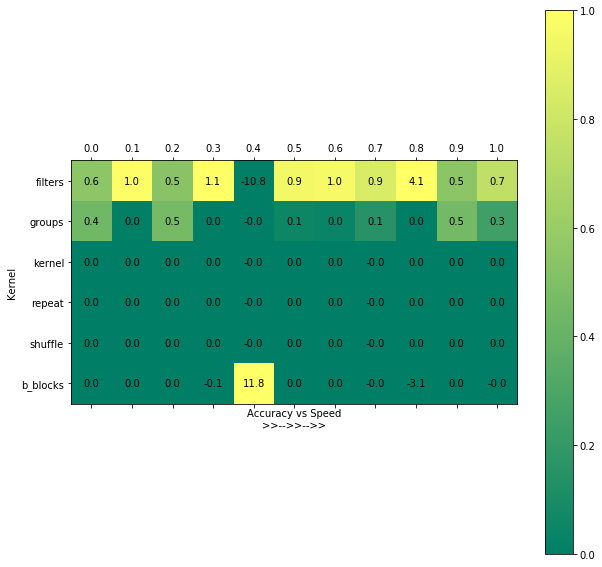

In [78]:
mp.get_matrix_plot(matrix, prettify_labels(labels).values(), ["{0:0.1f}".format(x) for x in percentiles], "Kernel", False)